In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset


In [60]:
# 讀取 CSV 檔案
file_path = "資料前處理/merged_stocks_sorted.csv"
df = pd.read_csv(file_path)
print(df.head())

           日期        成交股數           成交金額    開盤價    最高價    最低價    收盤價   漲跌價差  \
0  2010-10-21  20,697,571  2,347,730,094  114.0  114.5  112.5  113.0  -1.00   
1  2010-10-21  40,237,461  2,458,712,121   61.3   61.4   60.8   61.0   0.00   
2  2010-10-21   9,435,865  3,675,093,620  394.0  395.0  386.0  387.0  -5.50   
3  2010-10-22  16,111,879  1,833,691,206  114.5  114.5  113.0  114.0  +1.00   
4  2010-10-22  42,971,490  2,646,457,386   61.7   61.8   61.4   61.8  +0.80   

    成交筆數   SMA_5  ...   SMA_200       EMA_5      EMA_20        RSI       MACD  \
0  9,188  113.60  ...  129.9400  113.598253  115.156901  42.888466  -1.067839   
1  7,376   61.02  ...   60.9100   61.022536   61.126968  49.448148   0.078879   
2  6,346  385.20  ...  496.8100  389.029298  412.053709  32.870088 -18.545872   
3  6,509  113.20  ...  129.7525  113.732169  115.046720  45.751457  -1.032347   
4  9,208   61.00  ...   60.8945   61.281691   61.191067  55.601780   0.124750   

   MACD_signal  MACD_hist  Support_Lev

把資料整理成橫向合併 因為LSTM拿到的資料不能含有股票代碼的排序

In [61]:
import pandas as pd



# 使用 pivot_table 進行橫向合併
df_pivot = df.pivot(index="日期", columns="股票代碼")

# 修正欄位名稱：展平 MultiIndex，並加上股票代碼
df_pivot.columns = [f"{col[1]}_{col[0]}" for col in df_pivot.columns]

# 重置索引，確保日期仍然是欄位
df_pivot.reset_index(inplace=True)

# 輸出轉換後的 DataFrame
print(df_pivot.head())
print(df_pivot.columns)
print(df_pivot.info())

df=df_pivot.dropna()
print(df.head())
print(df.info())

# 儲存合併後的 CSV
df.to_csv("merged_stocks_(訓練LSTM用).csv", index=False)


           日期   2317_成交股數   2330_成交股數  2454_成交股數      2317_成交金額  \
0  2010-10-21  20,697,571  40,237,461  9,435,865  2,347,730,094   
1  2010-10-22  16,111,879  42,971,490  7,146,883  1,833,691,206   
2  2010-10-25  46,473,212  38,700,363  6,582,630  5,436,268,687   
3  2010-10-26  17,656,603  37,964,025  4,277,923  2,082,389,977   
4  2010-10-27  16,083,156  28,106,224  8,172,843  1,881,557,596   

       2330_成交金額      2454_成交金額  2317_開盤價  2330_開盤價  2454_開盤價  ...  \
0  2,458,712,121  3,675,093,620     114.0      61.3     394.0  ...   
1  2,646,457,386  2,771,465,394     114.5      61.7     392.5  ...   
2  2,398,665,034  2,589,838,110     114.0      62.0     390.0  ...   
3  2,359,307,050  1,680,229,085     119.0      62.2     396.0  ...   
4  1,747,861,763  3,159,225,055     118.0      62.3     391.0  ...   

   2454_MACD_signal  2317_MACD_hist  2330_MACD_hist  2454_MACD_hist  \
0        -16.016488       -0.221096       -0.109050       -2.529384   
1        -16.457288       -0.14848

In [64]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt

# 讀取數據
file_path = "merged_stocks_(訓練LSTM用).csv"
df = pd.read_csv(file_path)


# 轉換日期
df["日期"] = pd.to_datetime(df["日期"])
df = df.sort_values(by=["日期"]).reset_index(drop=True)

print(df.info())
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3474 entries, 0 to 3473
Data columns (total 64 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   日期                     3474 non-null   datetime64[ns]
 1   2317_成交股數              3474 non-null   object        
 2   2330_成交股數              3474 non-null   object        
 3   2454_成交股數              3474 non-null   object        
 4   2317_成交金額              3474 non-null   object        
 5   2330_成交金額              3474 non-null   object        
 6   2454_成交金額              3474 non-null   object        
 7   2317_開盤價               3474 non-null   float64       
 8   2330_開盤價               3474 non-null   float64       
 9   2454_開盤價               3474 non-null   float64       
 10  2317_最高價               3474 non-null   float64       
 11  2330_最高價               3474 non-null   float64       
 12  2454_最高價               3474 non-null   float64       
 13  231

Epoch 1, Train Loss: 0.0135, Test Loss: 0.0441
Epoch 2, Train Loss: 0.0112, Test Loss: 0.0465
Epoch 3, Train Loss: 0.0098, Test Loss: 0.0455
Epoch 4, Train Loss: 0.0078, Test Loss: 0.0452
Epoch 5, Train Loss: 0.0068, Test Loss: 0.0430
Epoch 6, Train Loss: 0.0061, Test Loss: 0.0417
Epoch 7, Train Loss: 0.0052, Test Loss: 0.0453
Epoch 8, Train Loss: 0.0049, Test Loss: 0.0430
Epoch 9, Train Loss: 0.0043, Test Loss: 0.0411
Epoch 10, Train Loss: 0.0045, Test Loss: 0.0375
Epoch 11, Train Loss: 0.0048, Test Loss: 0.0517
Epoch 12, Train Loss: 0.0042, Test Loss: 0.0409
Epoch 13, Train Loss: 0.0039, Test Loss: 0.0426
Epoch 14, Train Loss: 0.0035, Test Loss: 0.0341
Epoch 15, Train Loss: 0.0035, Test Loss: 0.0344
Epoch 16, Train Loss: 0.0036, Test Loss: 0.0355
Epoch 17, Train Loss: 0.0036, Test Loss: 0.0388
Epoch 18, Train Loss: 0.0035, Test Loss: 0.0381
Epoch 19, Train Loss: 0.0034, Test Loss: 0.0372
Epoch 20, Train Loss: 0.0029, Test Loss: 0.0323
Epoch 21, Train Loss: 0.0034, Test Loss: 0.0317
E

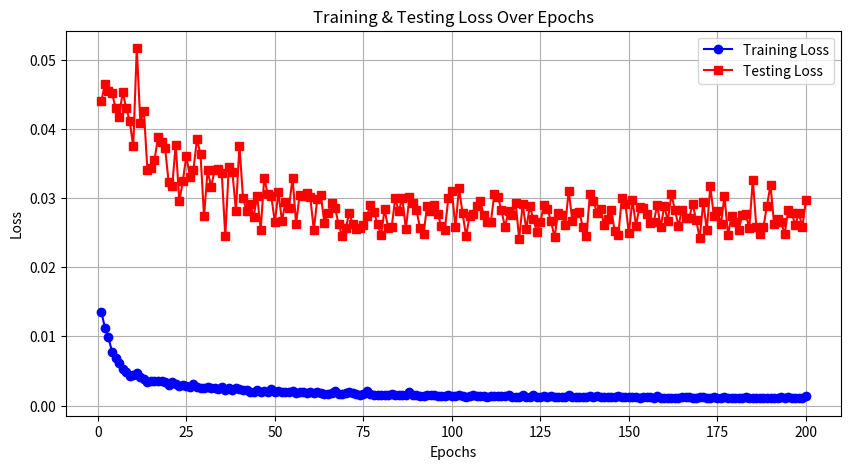

In [99]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt

# 讀取數據
file_path = "merged_stocks_(訓練LSTM用).csv"
df = pd.read_csv(file_path)


# 轉換日期
df["日期"] = pd.to_datetime(df["日期"])
df = df.sort_values(by=["日期"]).reset_index(drop=True)


# 選擇所有要預測的數值型特徵
features = [
    "2317_成交股數", "2330_成交股數", "2454_成交股數",
    "2317_成交金額", "2330_成交金額", "2454_成交金額",
    "2317_開盤價", "2330_開盤價", "2454_開盤價",
    "2317_最高價", "2330_最高價", "2454_最高價",
    "2317_最低價", "2330_最低價", "2454_最低價",
    "2317_收盤價", "2330_收盤價", "2454_收盤價",
    "2317_漲跌價差", "2330_漲跌價差", "2454_漲跌價差",
    "2317_成交筆數", "2330_成交筆數", "2454_成交筆數",
    
    # 移動平均線 (SMA)
    "2317_SMA_5", "2330_SMA_5", "2454_SMA_5",
    "2317_SMA_20", "2330_SMA_20", "2454_SMA_20",
    "2317_SMA_60", "2330_SMA_60", "2454_SMA_60",
    "2317_SMA_50", "2330_SMA_50", "2454_SMA_50",
    "2317_SMA_200", "2330_SMA_200", "2454_SMA_200",

    # 指數移動平均線 (EMA)
    "2317_EMA_5", "2330_EMA_5", "2454_EMA_5",
    "2317_EMA_20", "2330_EMA_20", "2454_EMA_20",

    # 技術指標
    "2317_RSI", "2330_RSI", "2454_RSI",
    "2317_MACD", "2330_MACD", "2454_MACD",
    "2317_MACD_signal", "2330_MACD_signal", "2454_MACD_signal",
    "2317_MACD_hist", "2330_MACD_hist", "2454_MACD_hist",

    # 支撐與壓力
    "2317_Support_Level", "2330_Support_Level", "2454_Support_Level",
    "2317_Resistance_Level", "2330_Resistance_Level", "2454_Resistance_Level"
]


# 清理數據
df[features] = df[features].replace(",", "", regex=True)
df[features] = df[features].replace("X0.00", "0")
df[features] = df[features].astype(float)

# 標準化數據
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# 建立時間序列資料
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length])  # 預測整個 feature vector
    return np.array(X), np.array(y)

seq_length = 30  # 用 30 天預測下一天
data = df[features].values
X, y = create_sequences(data, seq_length)

# 轉換為 PyTorch 張量
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# **切分訓練集與測試集**
train_size = int(len(X) * 0.8)  # 80% 訓練、20% 測試
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 創建 DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 建立 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)
        return self.fc(lstm_out[:, -1, :])  # 取最後一個時間步的輸出

model = LSTMModel(input_size=len(features), hidden_size=64, num_layers=2, output_size=len(features))

# 設定 loss function 和 optimizer
criterion = nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99)


epochs = 200
train_losses = []
test_losses = []

for epoch in range(epochs):
    # 訓練階段
    model.train()
    total_train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 測試階段（不更新權重）
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            output = model(batch_X)
            loss = criterion(output, batch_y)
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

# 繪製 loss 曲線
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", color='b', marker='o')
plt.plot(range(1, epochs + 1), test_losses, label="Testing Loss", color='r', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Testing Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [85]:
# 儲存模型
torch.save(model.state_dict(), "stock_lstm_modelv1.1.pth")
print("模型已儲存！")

模型已儲存！


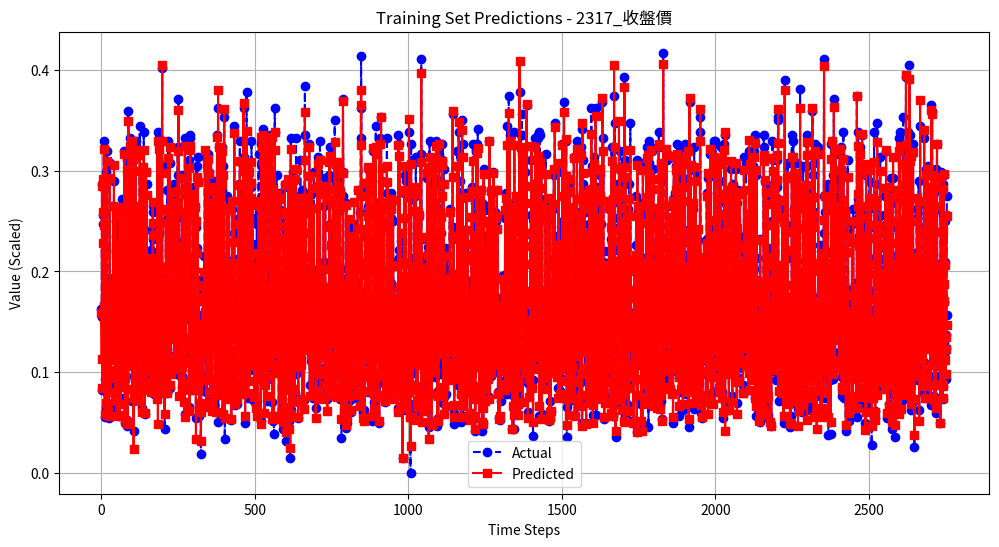

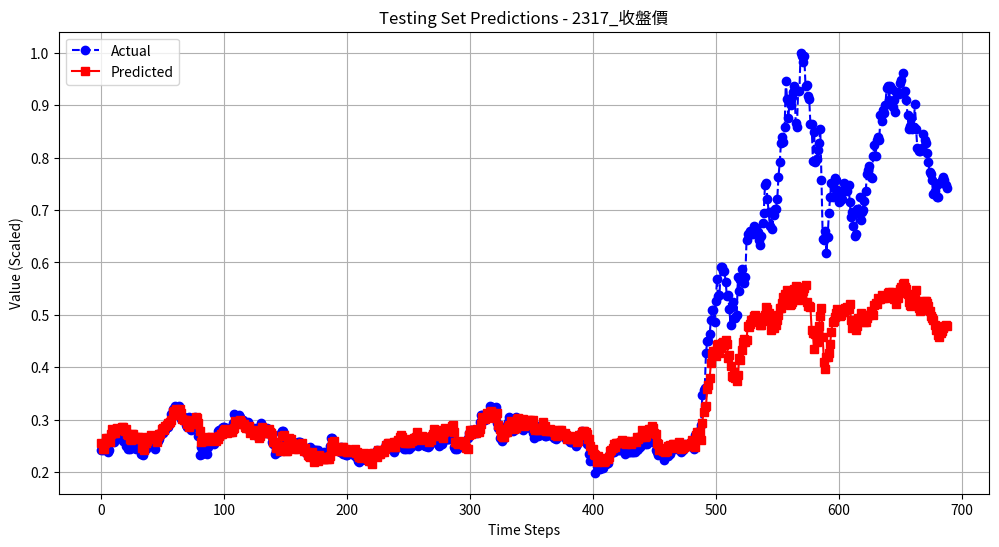

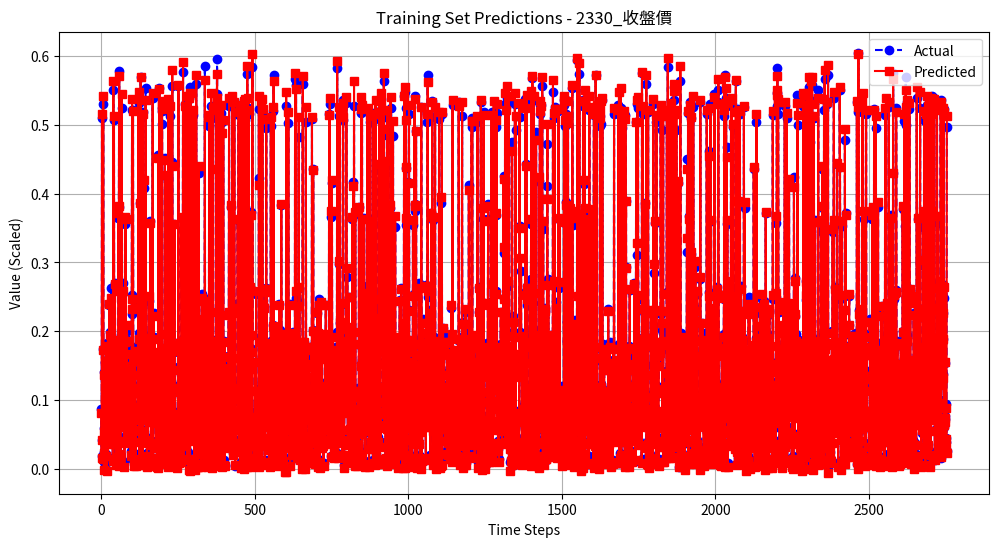

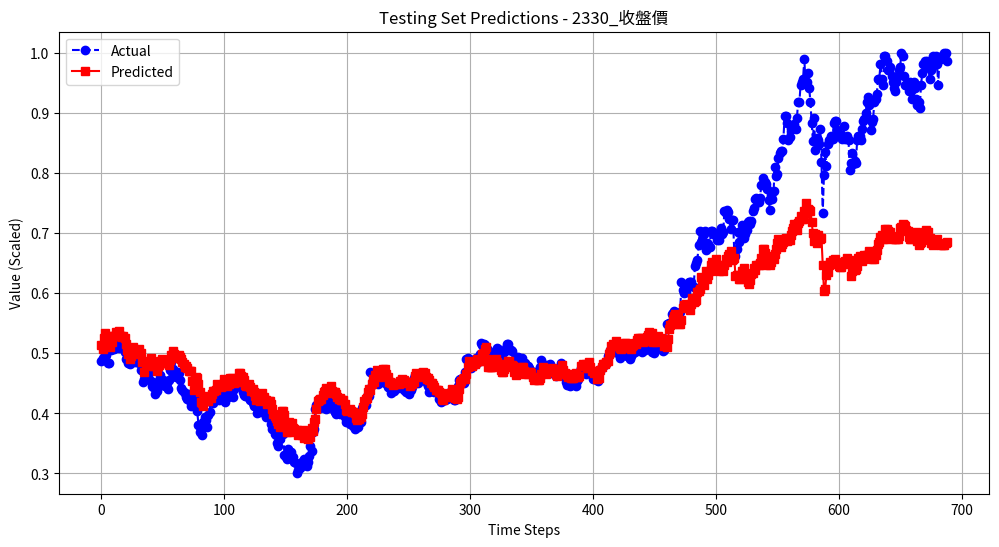

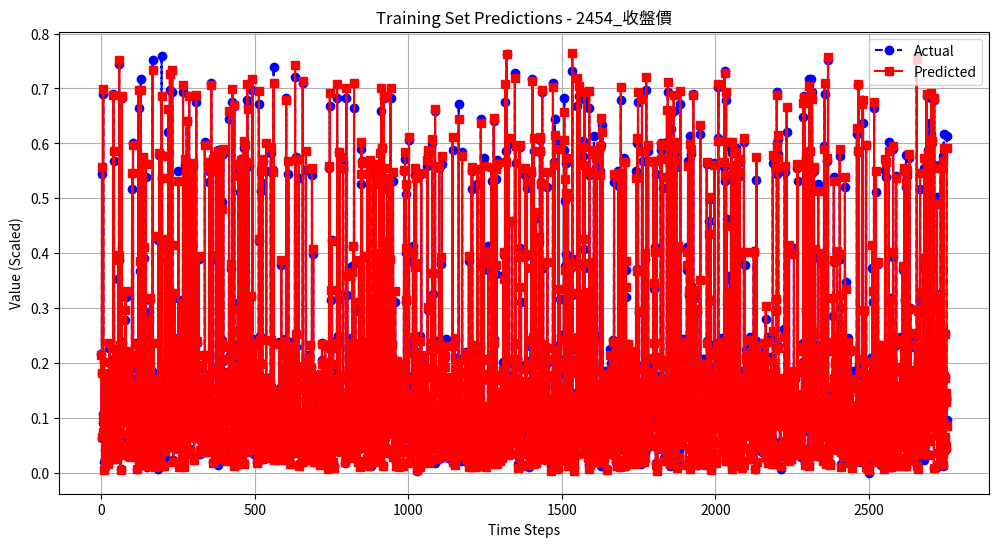

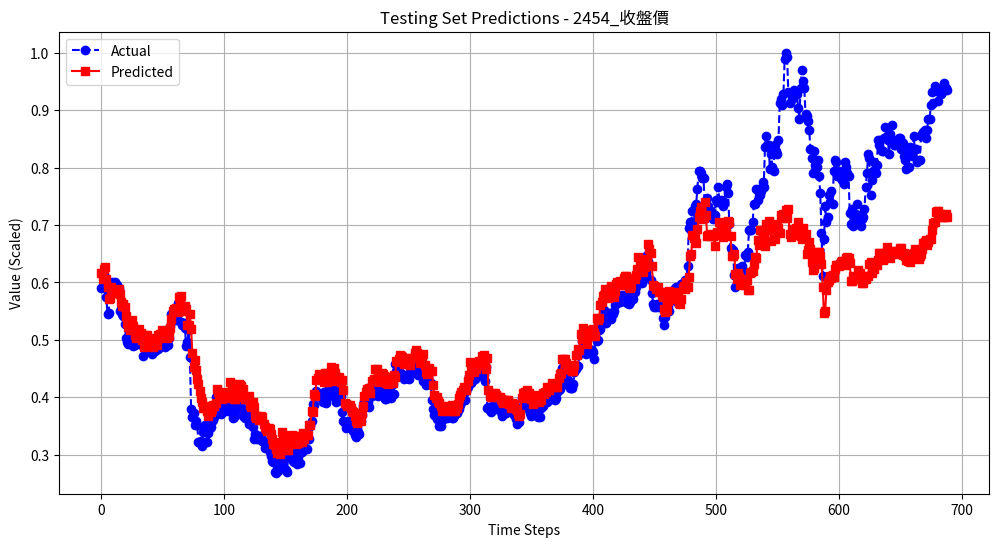

In [98]:
from matplotlib.font_manager import FontProperties
# 使用正確的字體路徑
font = FontProperties(fname='/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc')

# 設置中文顯示
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK SC']  # 指定為簡體中文，若需要繁體可改成 'Noto Sans CJK TC'
plt.rcParams['font.family'] = font.get_name()  # 設置默認字體為指定字體
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題
# 繪製預測結果與真實數據的對比圖
def plot_predictions(true_values, predicted_values, title, feature_idx, feature_name):
    plt.figure(figsize=(12, 6))
    plt.plot(true_values[:, feature_idx], label="Actual", color='b', linestyle='dashed', marker='o')
    plt.plot(predicted_values[:, feature_idx], label="Predicted", color='r', linestyle='solid', marker='s')
    
    plt.xlabel("Time Steps")
    plt.ylabel("Value (Scaled)")
    plt.title(f"{title} - {feature_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

# 設定模型為評估模式
model.eval()

# 取得訓練集預測值
train_predictions = []
train_actuals = []
with torch.no_grad():
    for batch_X, batch_y in train_loader:
        output = model(batch_X)
        train_predictions.append(output.numpy())
        train_actuals.append(batch_y.numpy())

train_predictions = np.concatenate(train_predictions, axis=0)
train_actuals = np.concatenate(train_actuals, axis=0)

# 取得測試集預測值
test_predictions = []
test_actuals = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        output = model(batch_X)
        test_predictions.append(output.numpy())
        test_actuals.append(batch_y.numpy())

test_predictions = np.concatenate(test_predictions, axis=0)
test_actuals = np.concatenate(test_actuals, axis=0)

# 繪製訓練集與測試集的預測對比圖
feature_idx = features.index("2317_收盤價")  # 選擇 "2317_收盤價" 來作為比較
plot_predictions(train_actuals, train_predictions, "Training Set Predictions", feature_idx, "2317_收盤價")
plot_predictions(test_actuals, test_predictions, "Testing Set Predictions", feature_idx, "2317_收盤價")
feature_idx = features.index("2330_收盤價")  # 選擇 "2330_收盤價" 來作為比較
plot_predictions(train_actuals, train_predictions, "Training Set Predictions", feature_idx, "2330_收盤價")
plot_predictions(test_actuals, test_predictions, "Testing Set Predictions", feature_idx, "2330_收盤價")
feature_idx = features.index("2454_收盤價")  # 選擇 "2454_收盤價" 來作為比較
plot_predictions(train_actuals, train_predictions, "Training Set Predictions", feature_idx, "2454_收盤價")
plot_predictions(test_actuals, test_predictions, "Testing Set Predictions", feature_idx, "2454_收盤價")


推論測試

In [92]:
# 選擇所有要預測的數值型特徵
features = [
    "2317_成交股數", "2330_成交股數", "2454_成交股數",
    "2317_成交金額", "2330_成交金額", "2454_成交金額",
    "2317_開盤價", "2330_開盤價", "2454_開盤價",
    "2317_最高價", "2330_最高價", "2454_最高價",
    "2317_最低價", "2330_最低價", "2454_最低價",
    "2317_收盤價", "2330_收盤價", "2454_收盤價",
    "2317_漲跌價差", "2330_漲跌價差", "2454_漲跌價差",
    "2317_成交筆數", "2330_成交筆數", "2454_成交筆數",
    
    # 移動平均線 (SMA)
    "2317_SMA_5", "2330_SMA_5", "2454_SMA_5",
    "2317_SMA_20", "2330_SMA_20", "2454_SMA_20",
    "2317_SMA_60", "2330_SMA_60", "2454_SMA_60",
    "2317_SMA_50", "2330_SMA_50", "2454_SMA_50",
    "2317_SMA_200", "2330_SMA_200", "2454_SMA_200",

    # 指數移動平均線 (EMA)
    "2317_EMA_5", "2330_EMA_5", "2454_EMA_5",
    "2317_EMA_20", "2330_EMA_20", "2454_EMA_20",

    # 技術指標
    "2317_RSI", "2330_RSI", "2454_RSI",
    "2317_MACD", "2330_MACD", "2454_MACD",
    "2317_MACD_signal", "2330_MACD_signal", "2454_MACD_signal",
    "2317_MACD_hist", "2330_MACD_hist", "2454_MACD_hist",

    # 支撐與壓力
    "2317_Support_Level", "2330_Support_Level", "2454_Support_Level",
    "2317_Resistance_Level", "2330_Resistance_Level", "2454_Resistance_Level"
]

print(len(features))

# 重新建立相同的模型架構
model = LSTMModel(input_size=63, hidden_size=64, num_layers=2, output_size=63)  # 確保參數一致
model.load_state_dict(torch.load("stock_lstm_modelv1.1.pth"))
model.eval()  # 設定為推論模式
print("模型已加載！")


63
模型已加載！


單次進行推論